One of the things I say when teaching about fingerprints and similarity searches is that there is no best fingerprint for every use case and that it's often useful to do similarity searches using different types of fingerprints and combine the results. If you use fingerprints that use quite different features to determine similarity (e.g. Morgan3 and atom pairs), this is a good way to take advantage of the differences between the fingerprints.

The goal of this post is to explore (and try to quantitate) the differences between the hit sets returned by doing similarity searches with different fingerprint types. 

For this post I will use the 59788 compounds tested in PubChem [Bioassay ID 373](https://pubchem.ncbi.nlm.nih.gov/bioassay/373). This is one of the PubChem screening assays, so the the compounds are taken from a screening deck and should be expected to be reasonably diverse with some small SAR clusters. You can directly access and download the compound structures [here](https://www.ncbi.nlm.nih.gov/pccompound?linkname=pcassay_pccompound&from_uid=373).

One thing that is worth keeping in mind is that these results almost certainly consider similarity values which are down close to and probably in the region of similarities observed between [random compounds](https://greglandrum.github.io/rdkit-blog/posts/2021-05-18-fingerprint-thresholds1.html). It may be worth refining the analysis in order to only consider similarities which are more significant, but that's for a possible future post.

In [3]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('tableau-colorblind10')

%matplotlib inline
%load_ext sql

import rdkit
print(rdkit.__version__)

2024.09.6


In [4]:
import gzip
with gzip.open('../data/Pubchem_AID373_compounds.sdf.gz','rb') as inf:
    with Chem.ForwardSDMolSupplier(inf) as suppl:
        dbmols = [x for x in suppl if x is not None]
len(dbmols)
    

59788

In [7]:
dbmols = ms

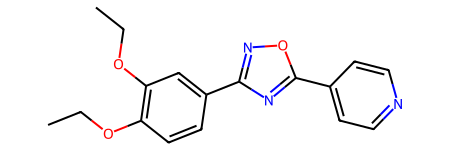

In [5]:
qry = Chem.MolFromSmiles('CCOC1=C(C=C(C=C1)C2=NOC(=N2)C3=CC=NC=C3)OCC') # https://pubchem.ncbi.nlm.nih.gov/compound/666359
qry

In [104]:
runs = [
    ('mfp2',rdFingerprintGenerator.GetMorganGenerator(radius=2)),
    ('ffp2',rdFingerprintGenerator.GetMorganGenerator(radius=2,
                                                  atomInvariantsGenerator=rdFingerprintGenerator.GetMorganAtomInvGen())),
    ('mfp3',rdFingerprintGenerator.GetMorganGenerator(radius=3)),
    ('ffp3',rdFingerprintGenerator.GetMorganGenerator(radius=3,
                                                  atomInvariantsGenerator=rdFingerprintGenerator.GetMorganAtomInvGen())),
    ('mfp1',rdFingerprintGenerator.GetMorganGenerator(radius=1)),
    ('ffp1',rdFingerprintGenerator.GetMorganGenerator(radius=1,
                                                  atomInvariantsGenerator=rdFingerprintGenerator.GetMorganAtomInvGen())),
    ('tt',rdFingerprintGenerator.GetTopologicalTorsionGenerator()),
    ('ap',rdFingerprintGenerator.GetAtomPairGenerator()),
    ('rdk5',rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)),
    ('rdk7',rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=7)),
]

accum = {}
for nm,fpg in runs:
    print(nm)
    fps = fpg.GetFingerprints(dbmols,numThreads=8)
    sims = DataStructs.BulkTanimotoSimilarity(fpg.GetFingerprint(qry),fps)
    accum[f'{nm}-b'] = sims

    fps = fpg.GetCountFingerprints(dbmols,numThreads=8)
    sims = DataStructs.BulkTanimotoSimilarity(fpg.GetCountFingerprint(qry),list(fps))
    accum[f'{nm}-c'] = sims



mfp2
ffp2
mfp3
ffp3
mfp1
ffp1
tt
ap
rdk5
rdk7


In [118]:
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D,Generate
def Gobbi2D_bits(mol,fpLen=2048):
    res = DataStructs.ExplicitBitVect(fpLen)
    for bit in Generate.Gen2DFingerprint(mol,Gobbi_Pharm2D.factory).GetOnBits():
        # the bits are not hashed, so we need to do so before we fold them:
        res.SetBit(hash((bit,))%fpLen)
    return res

In [119]:
from rdkit.Chem import rdMolDescriptors
from rdkit.Avalon import pyAvalonTools

func_runs = [
    ('gobbi2d',Gobbi2D_bits),
    ('avalon',pyAvalonTools.GetAvalonFP),
    ('avalon-c',pyAvalonTools.GetAvalonCountFP),
    ('pattern',Chem.PatternFingerprint),
]
for nm,func in func_runs:
    print(nm)
    fps = [func(m) for m in dbmols]
    sims = DataStructs.BulkTanimotoSimilarity(func(qry),fps)
    accum[nm] = sims


gobbi2d
avalon
avalon-c
pattern


Accumulate the overlaps between the hit sets:

In [120]:
from collections import defaultdict

nms = list(accum.keys())

ovls = defaultdict(dict)
topNs = [10,100,1000]
for i,nmi in enumerate(nms):
    topi = [x for s,x in sorted([(s,x) for x,s in enumerate(accum[nmi])],reverse=True)]
    for j in range(i):
        nmj = nms[j]
        topj = [x for s,x in sorted([(s,x) for x,s in enumerate(accum[nmj])],reverse=True)]
        for topN in topNs:
            ovls[nmi,nmj][topN] = set(topi[:topN]).intersection(topj[:topN])
ovls = dict(ovls)

Here's the full table of concordances between the fingerprints in the top 10, 100, and 1000 results:

In [121]:
from IPython.display import HTML

snms = sorted(nms)

html = "<table>"
ths = "".join(f"<th>{nm}</th>" for nm in snms)
html += f"<tr><td></td>{ths}</tr>\n"
ovls = dict(ovls)
for i,nm in enumerate(snms):
    row = f"<th>{nm}</th>"
    tds = []
    for j in range(len(snms)):
        if i==j:
            tds.append('<td></td>')
            continue
        nmi = snms[i]
        nmj = snms[j]
        if (nmi,nmj) not in ovls:
            nmi,nmj = nmj,nmi
        tds.append(f"<td>{len(ovls[nmi,nmj][10])}<br />{len(ovls[nmi,nmj][100])}<br />{len(ovls[nmi,nmj][1000])}</td>")
    tds = "".join(tds)
    row += tds
    html += f"<tr>{row}</tr>\n"

html += "</table>"

HTML(html)

,ap-b,ap-c,avalon,avalon-c,ffp1-b,ffp1-c,ffp2-b,ffp2-c,ffp3-b,ffp3-c,gobbi2d,mfp1-b,mfp1-c,mfp2-b,mfp2-c,mfp3-b,mfp3-c,pattern,rdk5-b,rdk5-c,rdk7-b,rdk7-c,tt-b,tt-c
ap-b,,977724,740245,740255,643317,838383,746281,742336,743260,641310,351235,743323,841380,747303,743337,746264,745314,535237,646292,646325,747279,646290,739298,741306
ap-c,977724,,646271,649291,642350,845445,748312,744378,745289,744349,349238,646349,748424,647312,648359,647280,648335,541295,652326,651364,650310,748317,741337,747359
avalon,740245,646271,,970588,757512,840399,857428,943357,851354,843320,537290,865552,948451,960529,950443,854429,951382,656518,783625,874502,873502,868487,854399,860446
avalon-c,740255,649291,970588,,750430,850402,846379,941371,844339,840344,537289,859459,957466,952458,950469,847399,946430,662532,763494,869478,861424,868458,850361,857393
ffp1-b,643317,642350,757512,750430,,760586,968671,854547,955573,852496,637263,982759,760562,867662,859529,859542,857469,550436,758563,854485,857458,749441,865514,863544
ffp1-c,838383,845445,840399,850402,760586,,860560,970722,855507,865633,539292,759539,980674,859527,868598,760461,864532,648385,841449,844473,740405,843442,960543,962579
ffp2-b,746281,748312,857428,846379,968671,860560,,975682,1082804,973649,649285,962582,861483,984658,978539,982598,979510,539385,861511,856479,963453,857447,970595,974611
ffp2-c,742336,744378,943357,941371,854547,970722,975682,,978669,990848,641314,852483,965564,971559,981655,876553,980625,632347,847430,945441,847387,944413,964578,967603
ffp3-b,743260,745289,851354,844339,955573,855507,1082804,978669,,981715,645277,954498,858450,974606,977543,986617,982547,534337,856443,854431,960397,854395,963538,967546
ffp3-c,641310,744349,843320,840344,852496,865633,973649,990848,981715,,641307,850440,863519,969535,979648,879565,982645,632314,847394,845413,847363,944383,960548,963570


Look at the highest overlaps (most similar results) for each FP:

In [124]:
snms = sorted(nms)

ovls = dict(ovls)
for i in range(len(snms)):
    print('-'*70)
    print(snms[i])
    for cnt in (10,100,1000):
        row = []
        for j in range(len(snms)):
            if i==j:
                continue
            nmi = snms[i]
            nmj = snms[j]
            if (nmi,nmj) not in ovls:
                nmi,nmj = nmj,nmi
            row.append((len(ovls[nmi,nmj][cnt]),j))
        row = sorted(row,reverse=True)
        nbrs = []
        for j in range(3):
            nbrs.append(f'{snms[row[j][1]]}({row[j][0]})')
        print(f'\t{cnt: 5d}',f'{nbrs[0]:13s}',f'{nbrs[1]:13s}',f'{nbrs[2]:13s}',)


----------------------------------------------------------------------
ap-b
	   10 ap-c(9)       mfp1-c(8)     ffp1-c(8)    
	  100 ap-c(77)      gobbi2d(51)   rdk7-b(47)   
	 1000 ap-c(724)     ffp1-c(383)   mfp1-c(380)  
----------------------------------------------------------------------
ap-c
	   10 ap-b(9)       ffp1-c(8)     tt-c(7)      
	  100 ap-b(77)      rdk5-b(52)    rdk5-c(51)   
	 1000 ap-b(724)     ffp1-c(445)   mfp1-c(424)  
----------------------------------------------------------------------
avalon
	   10 mfp3-c(9)     mfp2-c(9)     mfp2-b(9)    
	  100 rdk5-b(83)    rdk5-c(74)    rdk7-b(73)   
	 1000 rdk5-b(625)   avalon-c(588) mfp1-b(552)  
----------------------------------------------------------------------
avalon-c
	   10 mfp3-c(9)     mfp2-c(9)     mfp2-b(9)    
	  100 avalon(70)    rdk5-c(69)    rdk7-c(68)   
	 1000 avalon(588)   pattern(532)  rdk5-b(494)  
----------------------------------------------------------------------
ffp1-b
	   10 mfp1-b(9)     ffp

# Do some statistics

Those were just results for a single query molecule. Let's try and get more robust results by picking 500 molecules and looking at statistics for the overlaps:

In [232]:
import random
random.seed(0xbad5eed)
order = list(range(len(dbmols)))
random.shuffle(order)


nToDo = 500
order = order[:500]



accum = {}
for nm,fpg in runs:
    print(nm)
    fps = list(fpg.GetFingerprints(dbmols,numThreads=8))
    taccum = []
    for i in order:
        qry = fps[i]
        sims = [(sim,j) for j,sim in enumerate(DataStructs.BulkTanimotoSimilarity(qry,fps))]
        # remove the self similarity
        del sims[i]
        sims = sorted(sims,reverse=True)[:1000]
        taccum.append(sims)
    accum[f'{nm}-b'] = taccum

    fps = list(fpg.GetCountFingerprints(dbmols,numThreads=8))
    taccum = []
    for i in order:
        qry = fps[i]
        sims = [(sim,j) for j,sim in enumerate(DataStructs.BulkTanimotoSimilarity(qry,fps))]
        # remove the self similarity
        del sims[i]
        sims = sorted(sims,reverse=True)[:1000]
        taccum.append(sims)
    accum[f'{nm}-c'] = taccum

for nm,func in func_runs:
    print(nm)
    fps = [func(m) for m in dbmols]
    taccum = []
    for i in order:
        qry = fps[i]
        sims = [(sim,j) for j,sim in enumerate(DataStructs.BulkTanimotoSimilarity(qry,fps))]
        # remove the self similarity
        del sims[i]
        sims = sorted(sims,reverse=True)[:1000]
        taccum.append(sims)
    accum[nm] = taccum

mfp2
ffp2
mfp3
ffp3
mfp1
ffp1
tt
ap
rdk5
rdk7
gobbi2d
avalon
avalon-c
pattern


In [162]:
import pickle
import gzip
with gzip.open('./results/sim_overlaps.pkl.gz','wb+') as outf:
    pickle.dump(accum,outf)

Accumulate the overlaps:

In [164]:
from collections import defaultdict

nms = list(accum.keys())

ovls = defaultdict(dict)
topNs = [10,100,1000]
for i,nmi in enumerate(nms):
    nruns = len(accum[nmi])
    for j in range(i):
        nmj = nms[j]
        for topN in topNs:
            ovls[nmi,nmj][topN] = []
        for run in range(nruns):
            topi = [x for s,x in accum[nmi][run]]
            topj = [x for s,x in accum[nmj][run]]
            for topN in topNs:
                ovls[nmi,nmj][topN].append(len(set(topi[:topN]).intersection(topj[:topN])))
ovls = dict(ovls)

Find the most similar fingerprint types for each of the fingerprints, this time using the mean overlap across the 500 hit sets:

In [165]:
snms = sorted(nms)

for i in range(len(snms)):
    print('-'*70)
    print(snms[i])
    for cnt in (10,100,1000):
        row = []
        for j in range(len(snms)):
            if i==j:
                continue
            nmi = snms[i]
            nmj = snms[j]
            if (nmi,nmj) not in ovls:
                nmi,nmj = nmj,nmi
            row.append((np.mean(ovls[nmi,nmj][cnt]),j))
        row = sorted(row,reverse=True)
        nbrs = []
        for j in range(3):
            nbrs.append(f'{snms[row[j][1]]:8s}({row[j][0]:5.1f})')
        print(f'\t{cnt: 5d}',f'{nbrs[0]:17s}',f'{nbrs[1]:17s}',f'{nbrs[2]:16s}',)


----------------------------------------------------------------------
ap-b
	   10 ap-c    (  8.1)   ffp1-c  (  5.0)   mfp1-c  (  5.0) 
	  100 ap-c    ( 74.9)   ffp1-c  ( 40.7)   mfp1-c  ( 39.7) 
	 1000 ap-c    (732.9)   ffp1-c  (395.4)   mfp1-c  (370.4) 
----------------------------------------------------------------------
ap-c
	   10 ap-b    (  8.1)   ffp2-c  (  5.1)   ffp1-c  (  5.1) 
	  100 ap-b    ( 74.9)   ffp1-c  ( 43.6)   mfp1-c  ( 41.9) 
	 1000 ap-b    (732.9)   ffp1-c  (432.4)   mfp1-c  (402.0) 
----------------------------------------------------------------------
avalon
	   10 avalon-c(  5.6)   rdk7-b  (  5.4)   rdk5-b  (  5.3) 
	  100 avalon-c( 49.7)   rdk5-b  ( 49.3)   rdk7-b  ( 48.1) 
	 1000 avalon-c(452.4)   rdk5-b  (403.7)   rdk5-c  (370.2) 
----------------------------------------------------------------------
avalon-c
	   10 avalon  (  5.6)   rdk5-c  (  5.4)   rdk7-c  (  5.1) 
	  100 avalon  ( 49.7)   rdk5-c  ( 45.9)   rdk7-c  ( 43.2) 
	 1000 avalon  (452.4)   rdk5-

Look at histograms of the overlap sizes for a few different fingerprint pairs

In [217]:
def compare(prs,ovls=ovls):
    prs = list(prs)
    for i,pr in enumerate(prs):
        if pr not in ovls:
            pr = pr[1],pr[0]
        prs[i] = pr

    plt.figure(figsize=(12,5))
    for i,n in enumerate((100,1000)):
        plt.subplot(1,2,i+1)
        plt.hist([ovls[pr][n] for pr in prs],label=prs,bins=20);
        plt.xlim(0,n)
        plt.xlabel(f'n={n} overlap')
        #plt.title(pr)
        plt.legend()
    plt.tight_layout()

Start with [FeatureMorgan and Morgan](https://www.rdkit.org/docs/RDKit_Book.html#morgan-and-feature-morgan-fingerprints), where there is a reasonably large amount of overlap:

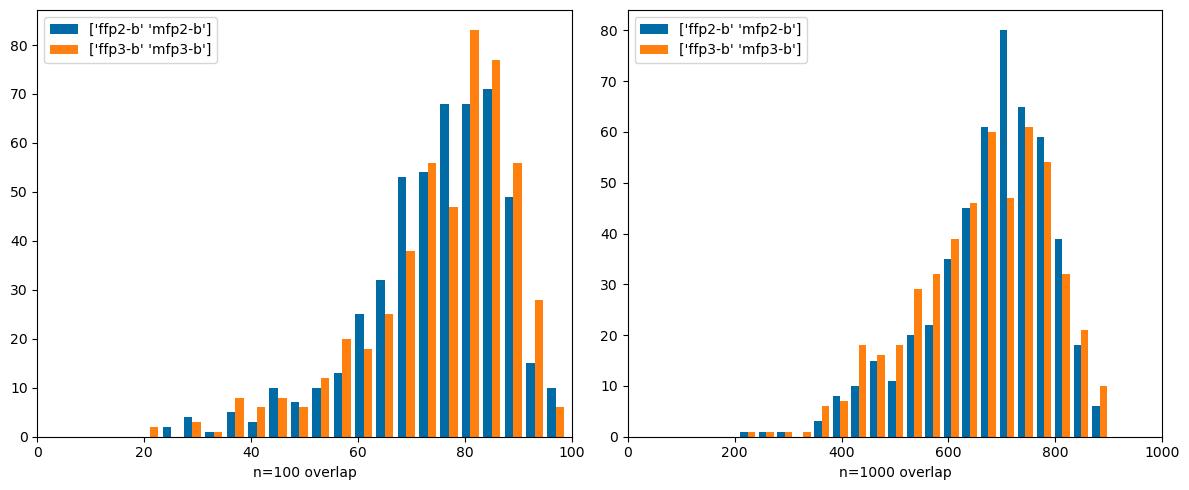

In [219]:
compare((('ffp2-b','mfp2-b'),('ffp3-b','mfp3-b')))

Now compare count-based and bit-based Morgan fingerprints. I expected the overlaps here to be higher:

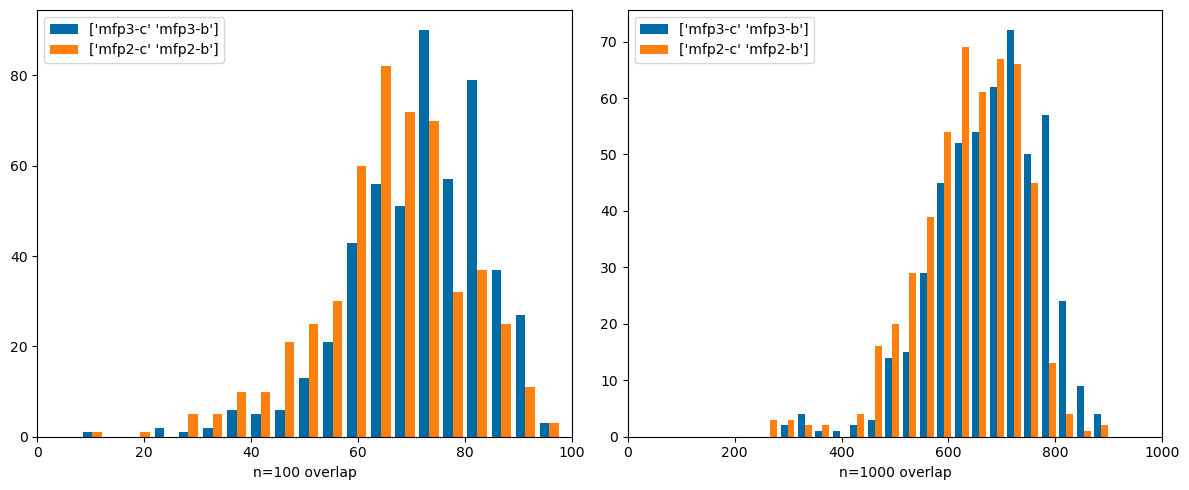

In [220]:
compare((('mfp3-c','mfp3-b'),('mfp2-c','mfp2-b'),))

Comparing very different types of fingerprints: count-based Morgan3 and both [Topological Torsions and Atom Pairs](https://www.rdkit.org/docs/RDKit_Book.html#atom-pair-and-topological-torsion-fingerprints) (these both use [count simulation](https://greglandrum.github.io/rdkit-blog/posts/2021-07-06-simulating-counts.html). Here there are significant differences. These are fingerprints that it would be interesting to use together.

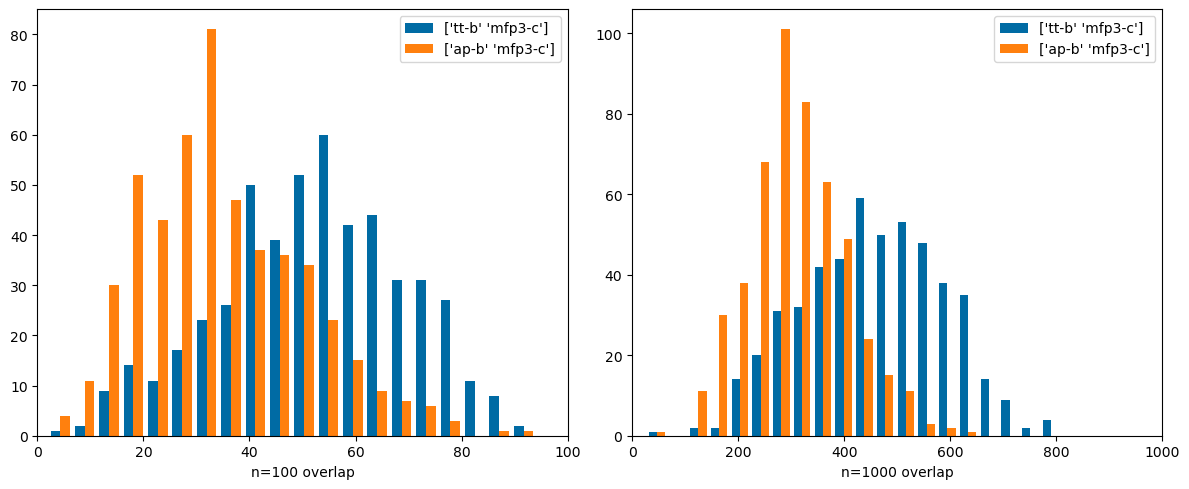

In [222]:
compare((('tt-b','mfp3-c'),('ap-b','mfp3-c')))

Same thing with bit-baseed Morgan3 and [RDK5](https://www.rdkit.org/docs/RDKit_Book.html#rdkit-fingerprints). Again, These are nicely complementary fingerprints:

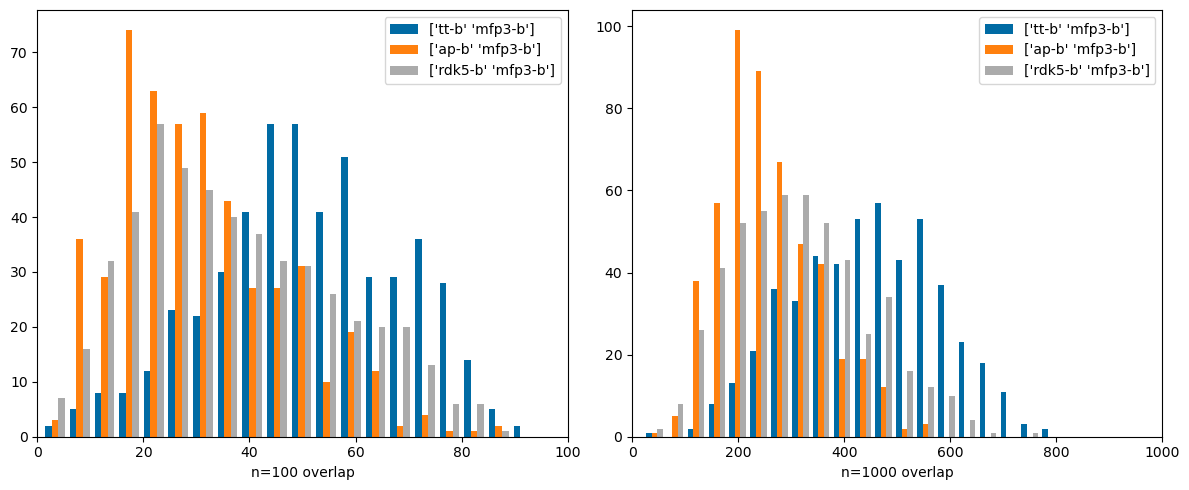

In [224]:
compare((('tt-b','mfp3-b'),('ap-b','mfp3-b'),('rdk5-b','mfp3-b')))

Finally compare Morgan3 with the [pattern fingerprint](https://www.rdkit.org/docs/RDKit_Book.html#pattern-fingerprints) (normally used for substructure screening, not similarity search), Gobbi2D (a 2D pharmacophore FP) and the Avalon FP. These are also nicely different from each other:

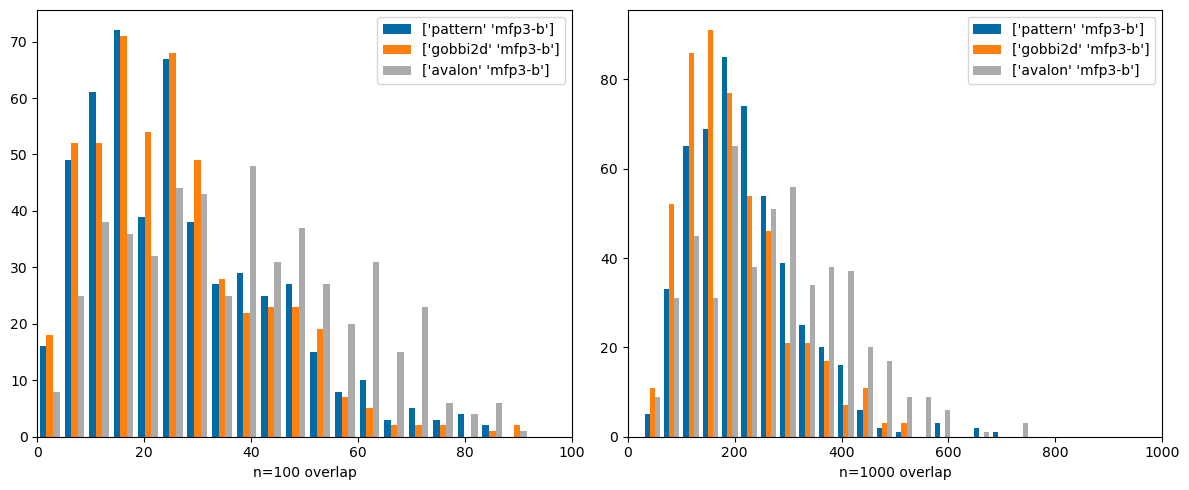

In [226]:
compare((('pattern','mfp3-b'),('gobbi2d','mfp3-b'),('avalon','mfp3-b')))